In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data

In [3]:
style.use('default')
output_folder = 'data'

# Load data

In [4]:
place_name = 'Delft'
local_crs = 'EPSG:28992'
sub_folder = 'Delft_02Mar2023'

In [5]:
walk_speed = 4.5   # in km/h
trip_times = [5, 10, 15]   # in minutes
buffer = 1000 * walk_speed * max(trip_times)/60
network_type = 'walk'
osm_crs = 'EPSG:3857'

In [6]:
place = ox.geocode_to_gdf(place_name).to_crs(local_crs)
extent = place.buffer(buffer, join_style=2)

In [7]:
g_leisure_tag_query = '["leisure"~"^(park)"]'
greenery = get_osm_data(g_leisure_tag_query, extent, 'bbox')

In [8]:
# all buildings with a residential tag
# following https://wiki.openstreetmap.org/wiki/Key:building residential, but without: hotel, terrace
r_tag_query_incl = '["building"~"^(apartments|bungalow|cabin|detached|dormitory|farm|ger|house|houseboat|residential|semidetached_house|static_caravan)"]'
residences_incl = get_osm_data(r_tag_query_incl, extent, 'bbox')

In [9]:
buildings = residences_incl.copy()
buildings = buildings[(buildings.geom_type == 'Polygon')|(buildings.geom_type == 'MultiPolygon')]

In [10]:
G = ox.graph_from_place(place_name, network_type=network_type, buffer_dist=3000)
paths = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True).to_crs(local_crs)

# Filter greenspaces

In [11]:
def greenspace_filter(gdf, local_crs,
                      threshold=0, place=None, min_area=10000, G=None):
    """
    gdf = geoseries of greenery polygons (e.g. greenery.geometry)
    return = a union of filtered polygons
    [optional] threshold to merge spaces in proximity (in meters)
    [optional] place geoseries of total area geometries (e.g. place_gdf.geometry)
    [optional] minimum area for greenspace filter, default value set
    [optional] graph which greenspace should intersect nodes and edges of
    """
    
    filtered = gdf.copy()
    
    # only polygons, no points or lines
    filtered = filtered[(filtered.geom_type == 'Polygon')|(filtered.geom_type == 'MultiPolygon')]
    
    #union of adjacent and overlapping polygons
    filtered['geometry'] = filtered.buffer(threshold)
    filtered = gpd.GeoDataFrame(filtered.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)
    filtered['geometry'] = filtered.buffer(-threshold)

    # filter on intersect with place
    if place is not None:
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(place.geometry), how="left", op='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
    # filter on minimum area
    if min_area > 0:
        filtered = filtered[filtered.geometry.area>=min_area]
    
    # filter on intersection with network
    if G:
        edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True).to_crs(local_crs)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(edges.reset_index(drop=True).geometry), how="left", op='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
        nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False).to_crs(local_crs)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(nodes.reset_index(drop=True).geometry), how="left", op='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])

    filtered.drop_duplicates(inplace=True)
    return filtered

In [12]:
# 1 hectare equals 10000 square meters
min_area = 10000
threshold = 0
greenspaces = greenspace_filter(greenery, local_crs, threshold=threshold, place=None, min_area=min_area, G=G)
'{} greenspaces fulfil the criteria for filtering'.format(len(greenspaces))

/Users/roosteeuwen/opt/anaconda3/envs/greenspace_accessibility/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/roosteeuwen/opt/anaconda3/envs/greenspace_accessibility/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


'38 greenspaces fulfil the criteria for filtering'

## Euclidean buffer

In [13]:
greenspaces['geom_crow_5'] = greenspaces.buffer(buffer/3)
greenspaces['geom_crow_10'] = greenspaces.buffer(2*buffer/3)
greenspaces['geom_crow_15'] = greenspaces.buffer(buffer)

## Isochrones

In [14]:
def set_travel_times(G, polygon, travel_speed):
    meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
    for u, v, k, data in G.edges(data=True, keys=True):
        # set edges within this greenspace to travel time 0
        if data['geometry'].intersects(polygon):
            data['time'] = 0
        else:
            data['time'] = data['length'] / meters_per_minute
    return G

In [15]:
def get_start_nodes(G, polygon, local_crs):
    
    start_nodes = []
    
    edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True).to_crs(local_crs)
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False).to_crs(local_crs)
    
    zone = gpd.clip(edges, polygon).geometry.buffer(1).unary_union
        
    if zone.geom_type == 'MultiPolygon':
        for sub_zone in gpd.geoseries.GeoSeries([geom for geom in zone.geoms]):
            intersecting = nodes[nodes.intersects(sub_zone)].index
            if len(intersecting)>0:
                start_nodes.append(intersecting[0])
    elif zone.geom_type == 'Polygon':
        intersecting = nodes[nodes.intersects(zone)].index
        if len(intersecting)>0:
            start_nodes.append(intersecting[0])

    return start_nodes

In [16]:
def get_iso_polys(G, start_node, trip_time, travel_speed, iso_colors, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []

    subgraph = nx.ego_graph(G, start_node, radius=trip_time, distance='time')

    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index('id')

    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
        edge_lines.append(edge_lookup)

    n = nodes_gdf.buffer(node_buff).geometry
    e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
    all_gs = list(n) + list(e)
    new_iso = gpd.GeoSeries(all_gs).unary_union

    # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
    if infill:
        new_iso = Polygon(new_iso.exterior)
    isochrone_polys.append(new_iso)
        
    return new_iso

In [17]:
def get_isochrones(G, gdf, trip_times, travel_speed=walk_speed, plot=False):

    G = ox.project_graph(G, to_crs=local_crs)
    iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

    for index, row in gdf.iterrows():

        G = set_travel_times(G, row.geometry, travel_speed)
        start_nodes = get_start_nodes(G, row.geometry, local_crs)
        
        for i, trip_time in enumerate(trip_times, start=1):
            trip_polys = [row.geometry]
            for start_node in start_nodes:
                poly = get_iso_polys(
                    G, start_node, trip_time, travel_speed, iso_colors,
                    edge_buff=25, node_buff=0, infill=True)
                trip_polys.append(poly)
            polys_union = gpd.geoseries.GeoSeries(trip_polys).unary_union

            col = 'geom_iso_{}'.format(trip_time)
            gdf.loc[index, col] = polys_union

        if plot:
            fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                                    node_size=0, bgcolor='k')
            for polygon, fc in zip(polys_union, iso_colors):
                patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
                ax.add_patch(patch)
            plt.show()

In [18]:
get_isochrones(G, greenspaces, trip_times)

##  Include population estimations

In [19]:
residences = gpd.read_file(os.path.join(os.path.join(output_folder, sub_folder), 'residences_population.geojson'))
residences.crs = local_crs

In [20]:
col = 'pop_count'
residences[col] = pd.to_numeric(residences[col])

In [21]:
# all people
delft_residences = gpd.clip(residences, place)

print('nr of buildings in Delft:                 ', len(delft_residences))
delft_pop = round(sum(delft_residences[col]), 0)
print('nr of people in Delft:                    ', str(delft_pop))

nr of buildings in Delft:                  1040
nr of people in Delft:                     102730


In [22]:
# people living within crowflight 15
crow15 = greenspaces.copy()
crow15 = crow15.set_geometry('geom_crow_15')
crow15 = gpd.clip(crow15, place)

delft_pop_crow15 = gpd.clip(residences, crow15)

print('nr of buildings within 15min crow-flight:  ', len(delft_pop_crow15))
crow15_pop = round(sum(delft_pop_crow15[col]), 0)
print('nr of people within 15min crow-flight:     ', str(crow15_pop))

nr of buildings within 15min crow-flight:   1039
nr of people within 15min crow-flight:      102695


In [23]:
# people living within isochrone 15
iso15 = greenspaces.copy()
iso15 = iso15.set_geometry('geom_iso_15')
iso15 = gpd.clip(iso15, place)

delft_pop_iso15 = gpd.clip(residences, iso15)

print('nr of buildings within 15min walk:         ', len(delft_pop_iso15))
iso15_pop = round(sum(delft_pop_iso15[col]), 0)
print('nr of people within 15min walk:            ', str(iso15_pop))

nr of buildings within 15min walk:          857
nr of people within 15min walk:             85920


In [24]:
print(
    """
    Out of {0} Delft inhabitants,
    only {1} people would be estimated not to have access 
    to greenspaces within 15min. as the crow flies ({2}%).
    But when including the street network into our metric, 
    we see that actually {3} people do not have access ({4}%)
    within 15min. of walking along the network. 
    """.format(
        int(delft_pop), 
        int(delft_pop-crow15_pop), 
        round(100*(delft_pop-crow15_pop)/delft_pop, 1),
        int(delft_pop-iso15_pop),
        round(100*(delft_pop-iso15_pop)/delft_pop, 1)
    ))


    Out of 102730 Delft inhabitants,
    only 35 people would be estimated not to have access 
    to greenspaces within 15min. as the crow flies (0.0%).
    But when including the street network into our metric, 
    we see that actually 16810 people do not have access (16.4%)
    within 15min. of walking along the network. 
    


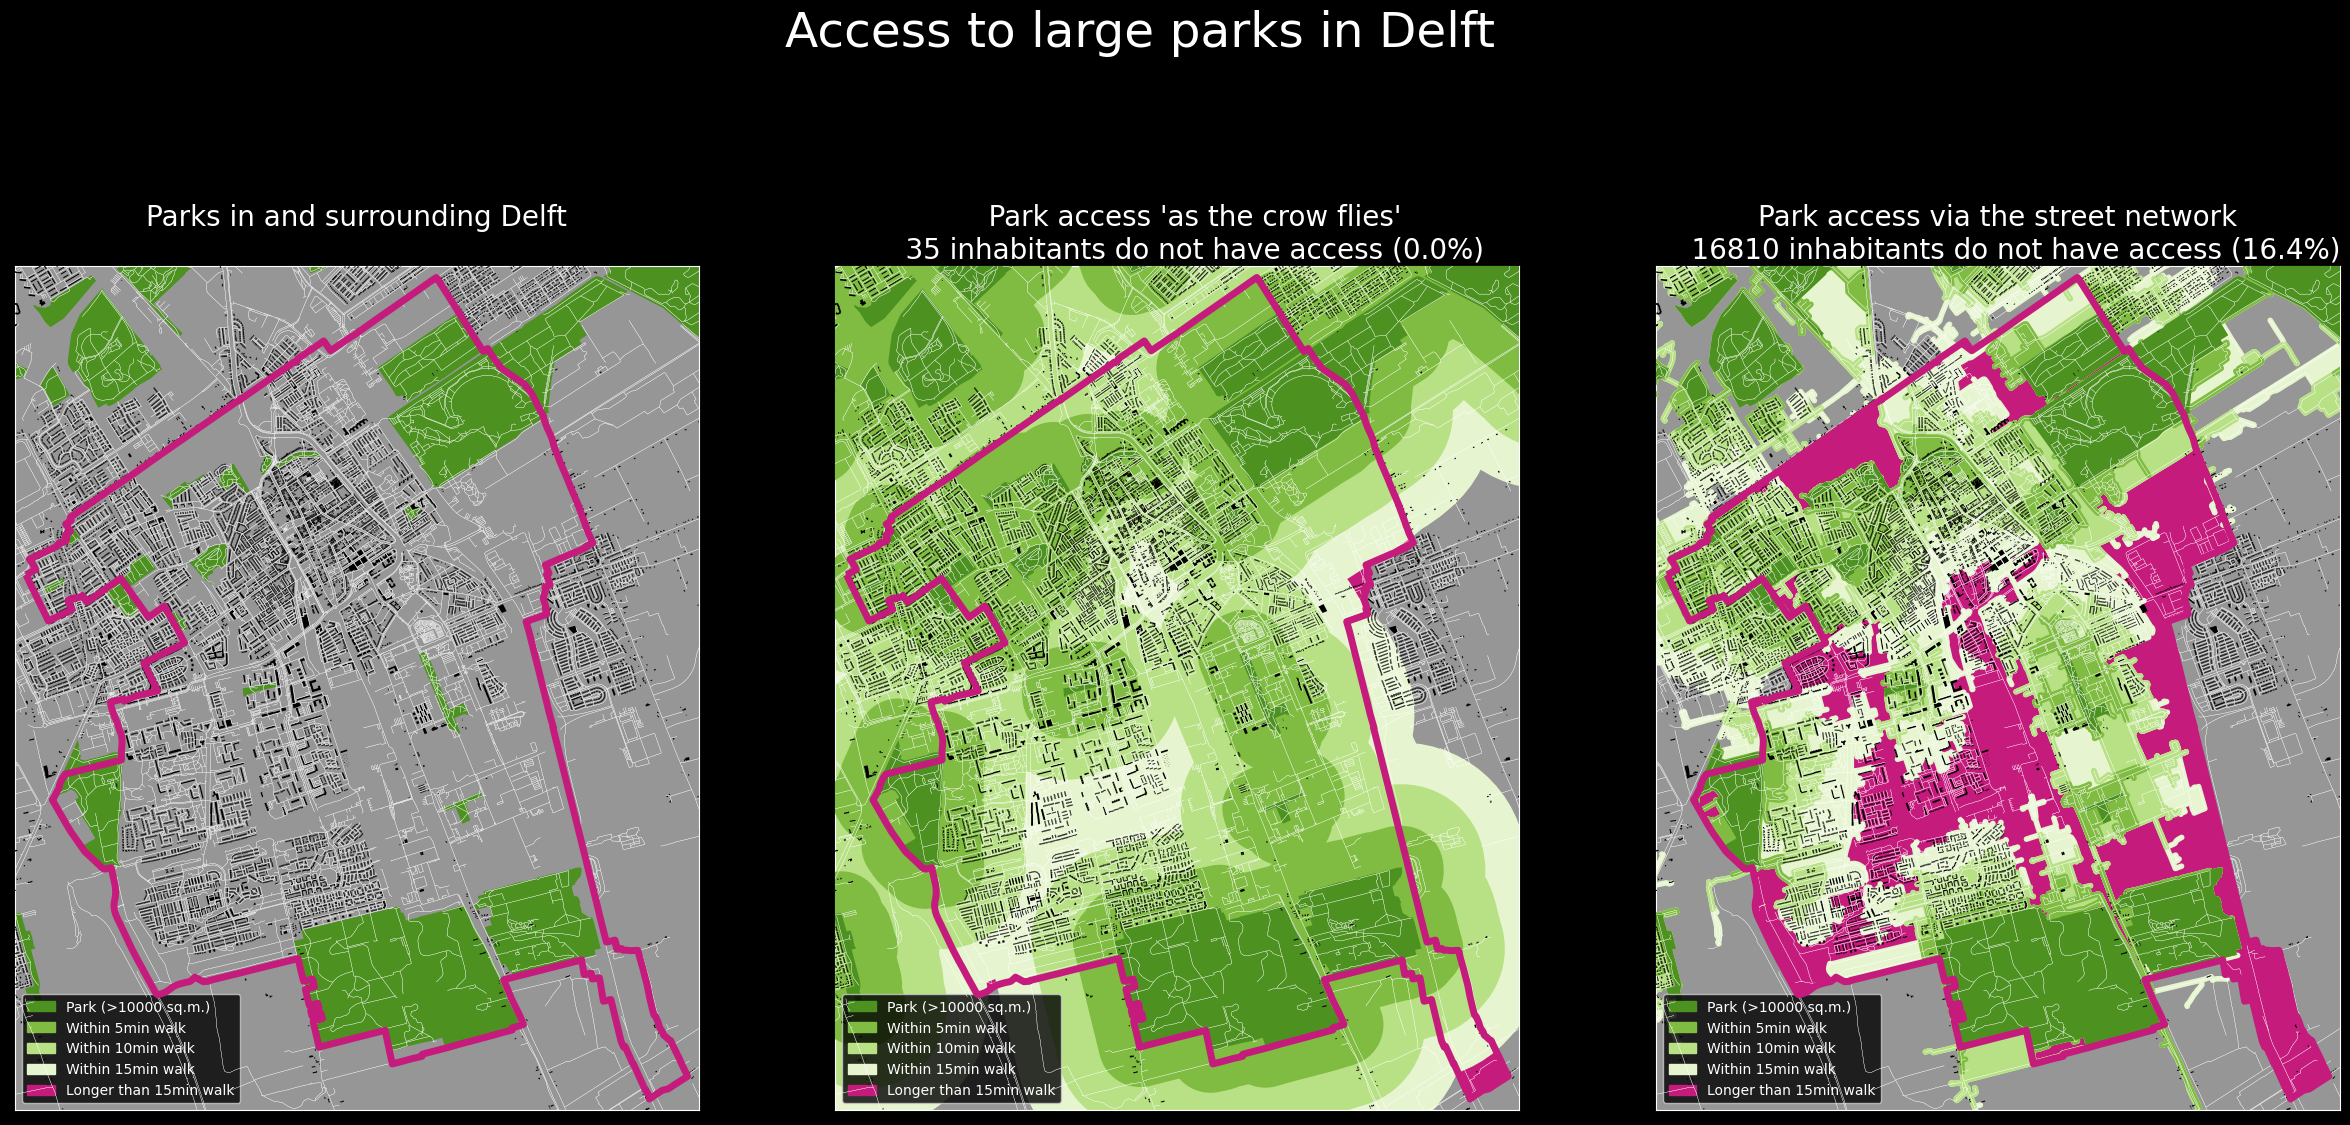

In [25]:
plt.style.use('dark_background')

background_color = '#969696'
pl_color = '#c51b7d'
wa_color = '#515151'
bl_color = 'black'
pt_color = 'white'
gs_color = '#4d9221'
t5_color = '#7fbc41'
t10_color = '#b8e186'
t15_color = '#e6f5d0'
alpha = 1
font1 = 35
font2 = 20



fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30,14))
fig.suptitle('Access to large parks in Delft', fontsize=font1)
fig.subplots_adjust(hspace=0.1)


gs = mpatches.Patch(color=gs_color, label='Park (>{} sq.m.)'.format(min_area))
t5 = mpatches.Patch(color=t5_color, label='Within 5min walk')
t10 = mpatches.Patch(color=t10_color, label='Within 10min walk')
t15 = mpatches.Patch(color=t15_color, label='Within 15min walk')
tno = mpatches.Patch(color=pl_color, label='Longer than 15min walk')


bbox = place.total_bounds
margin = 100
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])


axs0 = greenspaces.plot(ax=axs[0], color=gs_color, alpha=1, zorder=1)
buildings.plot(ax=axs0, color=bl_color, zorder=5)
paths.plot(ax=axs0, color=pt_color, linewidth=0.2, zorder=6)
place.plot(ax=axs0, facecolor='none', edgecolor=pl_color, linestyle='-', linewidth=5, zorder=7)
axs0.set_title('Parks in and surrounding Delft\n ', fontsize=font2)


axs1 = greenspaces.plot(ax=axs[1], color=gs_color, zorder=4)
greenspaces.set_geometry('geom_crow_15').plot(ax=axs1, figsize=(12, 20), color=t15_color, alpha=alpha, zorder=1)
greenspaces.set_geometry('geom_crow_10').plot(ax=axs1, figsize=(12, 20), color=t10_color, alpha=alpha, zorder=2)
greenspaces.set_geometry('geom_crow_5').plot(ax=axs1, figsize=(12, 20), color=t5_color, alpha=alpha, zorder=3)
buildings.plot(ax=axs1, color=bl_color, zorder=5)
paths.plot(ax=axs1, color=pt_color, linewidth=0.2, zorder=6)
place.plot(ax=axs1, color=pl_color, zorder=0)
place.plot(ax=axs1, facecolor='none', edgecolor=pl_color, linestyle='-', linewidth=5, zorder=7)
axs1.set_title("""
    Park access 'as the crow flies'
    {} inhabitants do not have access ({}%)""".format(
        int(delft_pop-crow15_pop),
        round(100*(delft_pop-crow15_pop)/delft_pop, 1)),
    fontsize=font2)


axs2 = greenspaces.plot(ax=axs[2], color=gs_color, zorder=4)
greenspaces.set_geometry('geom_iso_15').plot(ax=axs2, figsize=(12, 20), color=t15_color, alpha=alpha, zorder=1)
greenspaces.set_geometry('geom_iso_10').plot(ax=axs2, figsize=(12, 20), color=t10_color, alpha=alpha, zorder=2)
greenspaces.set_geometry('geom_iso_5').plot(ax=axs2, figsize=(12, 20), color=t5_color, alpha=alpha, zorder=3)
buildings.plot(ax=axs2, color=bl_color, zorder=5)
paths.plot(ax=axs2, color=pt_color, linewidth=0.2, zorder=6)
place.plot(ax=axs2, color=pl_color, zorder=0)
place.plot(ax=axs2, facecolor='none', edgecolor=pl_color, linestyle='-', linewidth=5, zorder=7)
axs2.set_title(
    """Park access via the street network
    {} inhabitants do not have access ({}%)""".format(
        int(delft_pop-iso15_pop),
        round(100*(delft_pop-iso15_pop)/delft_pop, 1)), 
    fontsize=font2)


for axs in [axs0, axs1, axs2]:
    axs.set_facecolor(background_color)
    axs.set_xlim(xlim)
    axs.set_ylim(ylim)
    axs.axes.get_xaxis().set_visible(False)
    axs.get_yaxis().set_visible(False)
    axs.legend(handles=[gs, t5, t10, t15, tno], loc='lower left')
    

plt.show()

#  Store output data

In [26]:
place_name_out = place_name.split(',')[0].replace(' ', '')
today = datetime.date.today().strftime("%d%b%Y")
output_sub_folder = os.path.join(output_folder, '{}_{}'.format(place_name_out, today))

In [27]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [28]:
output_file = os.path.join(output_sub_folder, 'greenspaces.geojson')
greenspaces = greenspaces.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
greenspaces.to_file(output_file, driver='GeoJSON')

In [29]:
output_file = os.path.join(output_sub_folder, 'paths.geojson')
paths = paths.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
paths.to_file(output_file, driver='GeoJSON')

In [30]:
output_file = os.path.join(output_sub_folder, 'residences_incl.geojson')
residences_incl = residences_incl.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
residences_incl.to_file(output_file, driver='GeoJSON')

In [31]:
output_file = os.path.join(output_sub_folder, 'place.geojson')
place = place.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
place.to_file(output_file, driver='GeoJSON')

In [32]:
output_file = os.path.join(output_sub_folder, 'G.graphml')
ox.save_graphml(G, output_file)